# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
# rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for `d7`

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [10]:
# get the corresponding dataframe1
train_data_d7 <- train_data_original$d7
train_data_d7 = na.omit(train_data_d7) # listwise deletion
head(train_data_d7)
any(is.na(train_data_d7))

,V1,V2,V3,time,status,V4,V5,V6,V7,V8,V9,V10
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<fct>,<int>,<dbl>,<fct>
1,2007,1114,1110,30.1,0,30.1,Male,68,Surgical Elective,20,31.60321,Cardio-Vascular
2,2007,1114,1111,30.1,0,30.1,Female,57,Medical,22,24.34176,Respiratory
3,2007,1114,1116,9.8,1,9.8,Female,68,Surgical Elective,25,17.99308,Cardio-Vascular
4,2007,598,1316,30.1,0,30.1,Male,47,Medical,16,33.74653,Orthopedic/Trauma
6,2007,365,1414,30.1,0,5.4,Male,47,Medical,21,45.00622,Respiratory
8,2007,980,1509,30.1,0,6.4,Male,58,Medical,26,26.77593,Metabolic


[1] FALSE

In [29]:
# create the task
tsks_train_d7_old <- TaskSurv$new("df7", backend = na.omit(train_data_original$d7), time = "time", event = "status")
## check the task
tsks_train_d7_old

<TaskSurv:df7> (1786 x 12)
* Target: time, status
* Properties: -
* Features (10):
  - fct (5): V1, V10, V2, V5, V7
  - int (3): V3, V6, V8
  - dbl (2): V4, V9

### Feature filtering
There are unobserved levels appearing when it comes to cross validation. Thus either `droplevels()` or do feature filtering.

In [32]:
###### feature filtering ######
# library("mlr3filters") # load the required library
# library("ranger")

# lrn = lrn("surv.ranger")
# lrn$param_set$values = list(importance = "impurity")

# # set up the filter
# filter = flt("importance", learner = lrn)
# filter$calculate(tsks_train_d7_old) # calculate the corresponding importance scores
# c_tab <- as.data.table(filter)
# c_tab # not working with score 66

### Data processing
Drop the `V2` column as there are too many levels (>400) in this dataset with 1800 rows. 

In [14]:
# drop the V2 column
train_data_d7 <- subset(train_data_d7, select = -c(V2))
head(train_data_d7)
# update the task
tsks_train_d7 <- TaskSurv$new("df7", backend = train_data_d7, time = "time", event = "status")
## check the task
tsks_train_d7

<TaskSurv:df7> (1786 x 11)
* Target: time, status
* Properties: -
* Features (9):
  - fct (4): V1, V10, V5, V7
  - int (3): V3, V6, V8
  - dbl (2): V4, V9

#### one-hot-encoding

In [9]:
# one hot encoder
library(data.table)
library(mltools)
train_oh_d7 <- one_hot(as.data.table(train_data_d7))
head(train_oh_d7)

V1_2007,V1_2008,V1_2009,V1_2011,V3,time,status,V4,V5_Female,V5_Male,⋯,V9,V10_Gastrointestinal,V10_Cardio-Vascular,V10_Other,V10_Metabolic,V10_Neurologic,V10_Orthopedic/Trauma,V10_Renal,V10_Respiratory,V10_Sepsis
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,1110,30.1,0,30.1,0,1,⋯,31.60321,0,1,0,0,0,0,0,0,0
1,0,0,0,1111,30.1,0,30.1,1,0,⋯,24.34176,0,0,0,0,0,0,0,1,0
1,0,0,0,1116,9.8,1,9.8,1,0,⋯,17.99308,0,1,0,0,0,0,0,0,0
1,0,0,0,1316,30.1,0,30.1,0,1,⋯,33.74653,0,0,0,0,0,1,0,0,0
1,0,0,0,1414,30.1,0,5.4,0,1,⋯,45.00622,0,0,0,0,0,0,0,1,0
1,0,0,0,1509,30.1,0,6.4,0,1,⋯,26.77593,0,0,0,1,0,0,0,0,0


In [10]:
# change names
# library(tidyverse)
# train_onehot_d7 %>%rename(V7.Surgical.Elective = V7.Surgical Elective, V7.Surgical.Emergency = V7.Surgical Emergency)
colnames(train_oh_d7)

[1] "V1_2007"               "V1_2008"               "V1_2009"              
 [4] "V1_2011"               "V3"                    "time"                 
 [7] "status"                "V4"                    "V5_Female"            
[10] "V5_Male"               "V6"                    "V7_Medical"           
[13] "V7_Surgical Elective"  "V7_Surgical Emergency" "V8"                   
[16] "V9"                    "V10_Gastrointestinal"  "V10_Cardio-Vascular"  
[19] "V10_Other"             "V10_Metabolic"         "V10_Neurologic"       
[22] "V10_Orthopedic/Trauma" "V10_Renal"             "V10_Respiratory"      
[25] "V10_Sepsis"

In [14]:
# names(train_oh_d7)[names(train_oh_d7) =="V7_Surgical Elective"] <-"V7_SElec"
# names(train_oh_d7)[names(train_oh_d7) =="V7_Surgical Emergency"] <-"V7_SEmer"
# names(train_oh_d7)[names(train_oh_d7) =="V10_Cardio-Vascular"] <-"V10_CV"
# names(train_oh_d7)[names(train_oh_d7) =="V10_Orthopedic/Trauma"] <-"V10_OT"
head(train_oh_d7)

V1_2007,V1_2008,V1_2009,V1_2011,V3,time,status,V4,V5_Female,V5_Male,⋯,V9,V10_Gastrointestinal,V10_CV,V10_Other,V10_Metabolic,V10_Neurologic,V10_OT,V10_Renal,V10_Respiratory,V10_Sepsis
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,1110,30.1,0,30.1,0,1,⋯,31.60321,0,1,0,0,0,0,0,0,0
1,0,0,0,1111,30.1,0,30.1,1,0,⋯,24.34176,0,0,0,0,0,0,0,1,0
1,0,0,0,1116,9.8,1,9.8,1,0,⋯,17.99308,0,1,0,0,0,0,0,0,0
1,0,0,0,1316,30.1,0,30.1,0,1,⋯,33.74653,0,0,0,0,0,1,0,0,0
1,0,0,0,1414,30.1,0,5.4,0,1,⋯,45.00622,0,0,0,0,0,0,0,1,0
1,0,0,0,1509,30.1,0,6.4,0,1,⋯,26.77593,0,0,0,1,0,0,0,0,0


## Hyperparameter Tuning for `d7`


In [15]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d7,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design) 
# Error in f(init, x[[i]]): non-conformable arrays
# Traceback:

# 1. run_benchmark(design)
# The problem is that omega in your case is matrix of dimensions 1 
# * 1. You should convert it to a vector if you wish to multiply t(X) %*% X by a scalar (that is omega)

INFO  [03:01:53.253] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [03:01:53.263] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 2/3) 
INFO  [03:01:54.221] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 3/3) 
INFO  [03:01:55.164] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 1/3) 
INFO  [03:01:56.107] [mlr3]  Finished benchmark 


In [16]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.816

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x560734b90498>,df7,surv.mboost,cv,3,0.8161204


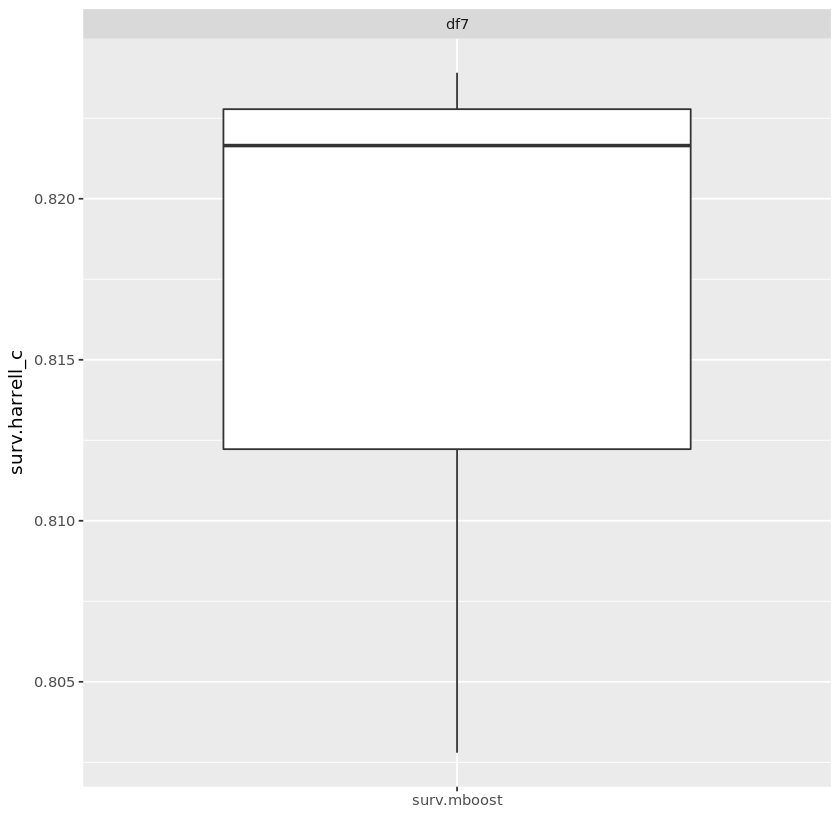

In [17]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [19]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d7, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [03:06:32.465] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df7' (iter 2/2) 
INFO  [03:06:32.512] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [03:06:32.518] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:06:32.553] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [03:06:32.565] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 2/2) 
INFO  [03:06:38.319] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 1/2) 
INFO  [03:06:43.692] [mlr3]  Finished benchmark 
INFO  [03:06:43.752] [bbotk] Result of batch 1: 
INFO  [03:06:43.755] [bbotk]  baselearner  family mstop  nu surv.harrell_c 
INFO  [03:06:43.755] [bbotk]        btree weibull   273 0.3      0.7638634 
INFO  [03:06:43.755] [bbotk]                                 uhash 
INFO  [03:06:43.755] [bbotk]  6d8f551b-3e14-4381-a68c-e10b76652557 
INFO  [03:06:43.757] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:06:43.785] [mlr3]  

In [20]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.815

surv.harrell_c 
     0.8149736

In [21]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "lognormal"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 245

[[1]]$nu
[1] 0.4

Step_1_3: autoplot the pre and tuned benchmark results

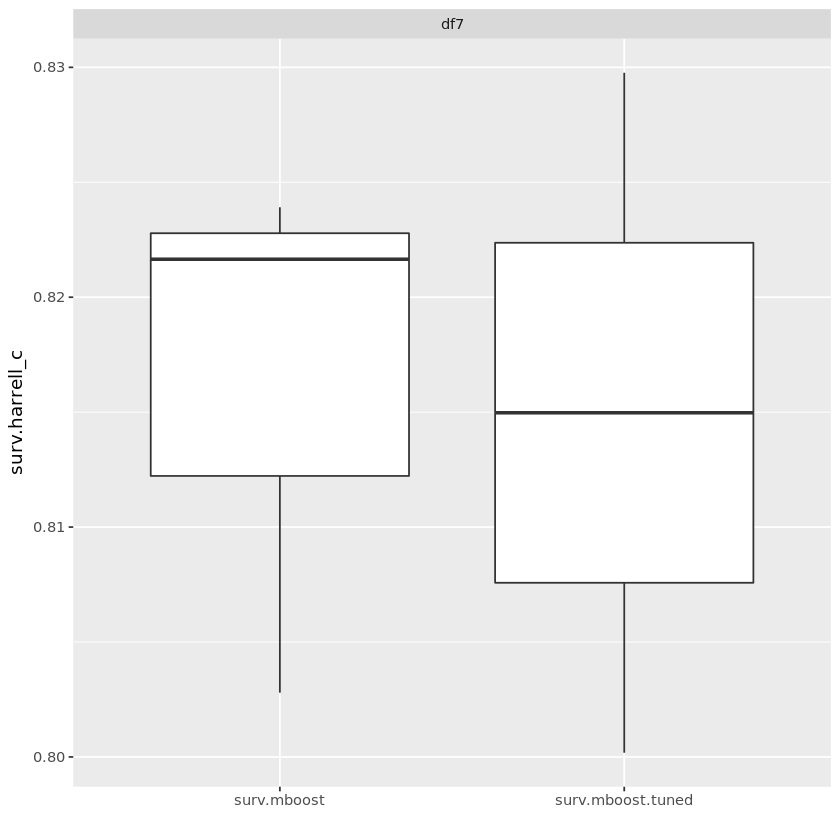

In [22]:
# autoplot the two boxplots
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [23]:
design <- benchmark_grid(
  tasks = tsks_train_d7,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [03:12:22.126] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [03:12:22.150] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 2/3) 
INFO  [03:12:33.852] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 3/3) 
INFO  [03:12:45.422] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 1/3) 
INFO  [03:12:57.686] [mlr3]  Finished benchmark 


In [34]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.818

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x56073b2e5b60>,df7,surv.mboost,cv,3,0.8176771


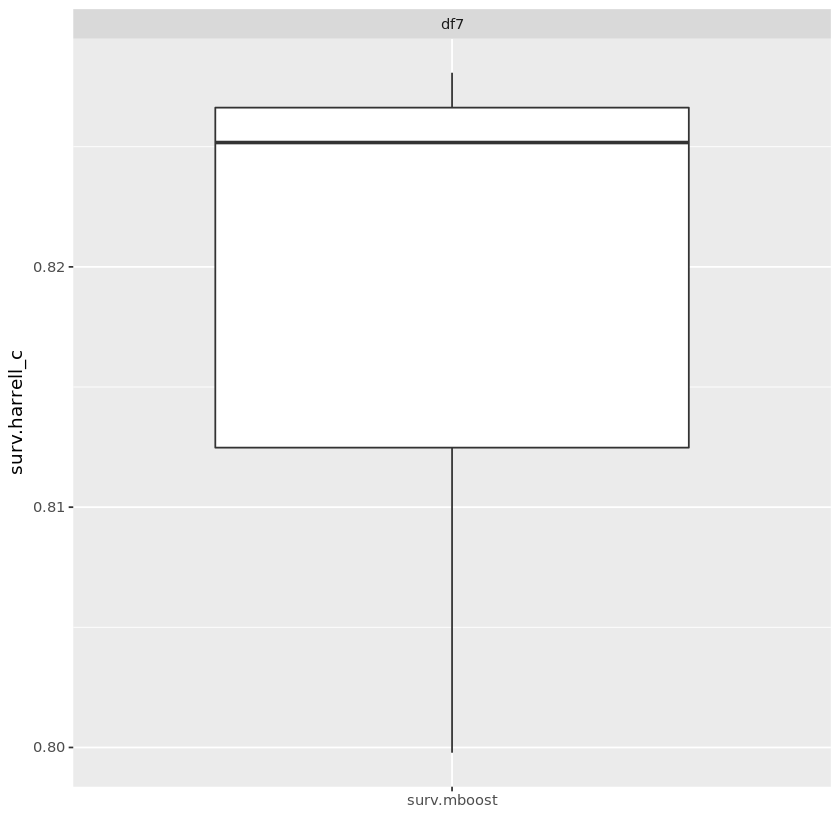

In [35]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [36]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d7, grid_auto_mb, outer_rsmp, store_models = TRUE)

INFO  [03:17:42.229] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df7' (iter 2/2) 
INFO  [03:17:42.263] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [03:17:42.268] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:17:42.294] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [03:17:42.303] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 1/2) 
INFO  [03:17:56.605] [mlr3]  Applying learner 'surv.mboost' on task 'df7' (iter 2/2) 
INFO  [03:18:10.594] [mlr3]  Finished benchmark 
INFO  [03:18:10.641] [bbotk] Result of batch 1: 
INFO  [03:18:10.643] [bbotk]  baselearner family mstop  nu surv.harrell_c 
INFO  [03:18:10.643] [bbotk]        btree cindex   217 0.5      0.8029144 
INFO  [03:18:10.643] [bbotk]                                 uhash 
INFO  [03:18:10.643] [bbotk]  886430bf-144b-49e1-8567-f07d9045c6c6 
INFO  [03:18:10.645] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:18:10.673] [mlr3]  Be

In [37]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.818

surv.harrell_c 
     0.8180201

In [39]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 50

[[1]]$nu
[1] 0.45

Step_1_3: boxplot the pre and after

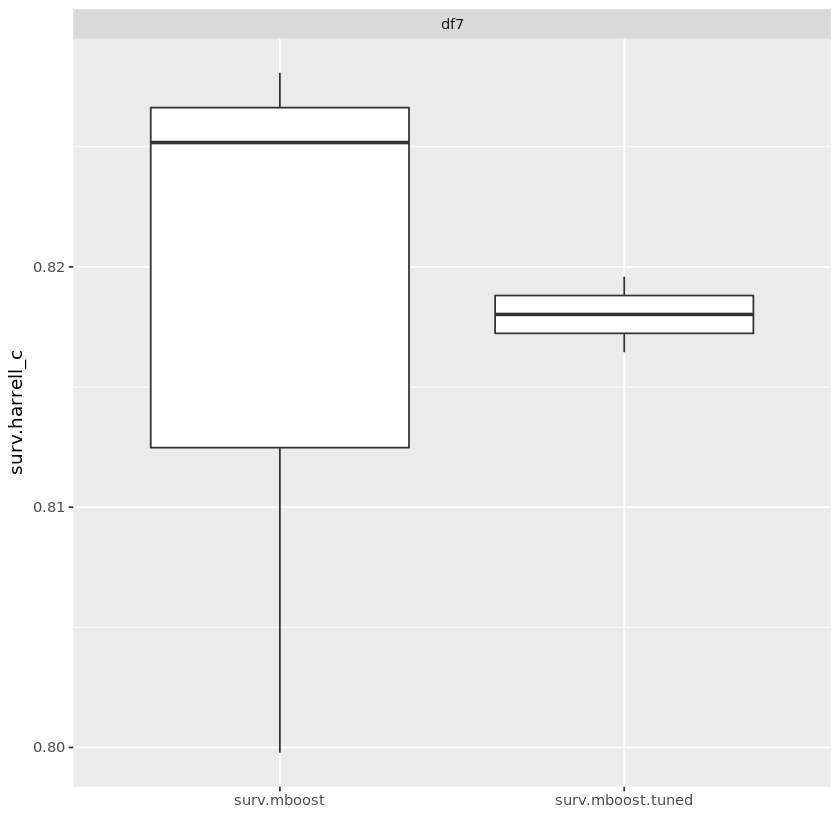

In [40]:
# autoplot the two boxplots
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [42]:
tsks_train_d7 # check task

<TaskSurv:df7> (1786 x 11)
* Target: time, status
* Properties: -
* Features (9):
  - fct (4): V1, V10, V5, V7
  - int (3): V3, V6, V8
  - dbl (2): V4, V9

In [43]:
# one hot encoder
library(data.table)
library(mltools)
train_oh_d7 <- one_hot(as.data.table(train_data_d7))
head(train_oh_d7)
# colnames(train_oh_d7)


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na




V1_2007,V1_2008,V1_2009,V1_2011,V3,time,status,V4,V5_Female,V5_Male,⋯,V9,V10_Gastrointestinal,V10_Cardio-Vascular,V10_Other,V10_Metabolic,V10_Neurologic,V10_Orthopedic/Trauma,V10_Renal,V10_Respiratory,V10_Sepsis
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,1110,30.1,0,30.1,0,1,⋯,31.60321,0,1,0,0,0,0,0,0,0
1,0,0,0,1111,30.1,0,30.1,1,0,⋯,24.34176,0,0,0,0,0,0,0,1,0
1,0,0,0,1116,9.8,1,9.8,1,0,⋯,17.99308,0,1,0,0,0,0,0,0,0
1,0,0,0,1316,30.1,0,30.1,0,1,⋯,33.74653,0,0,0,0,0,1,0,0,0
1,0,0,0,1414,30.1,0,5.4,0,1,⋯,45.00622,0,0,0,0,0,0,0,1,0
1,0,0,0,1509,30.1,0,6.4,0,1,⋯,26.77593,0,0,0,1,0,0,0,0,0


In [44]:
# change colnames
names(train_oh_d7)[names(train_oh_d7) =="V7_Surgical Elective"] <-"V7_SElec"
names(train_oh_d7)[names(train_oh_d7) =="V7_Surgical Emergency"] <-"V7_SEmer"
names(train_oh_d7)[names(train_oh_d7) =="V10_Cardio-Vascular"] <-"V10_CV"
names(train_oh_d7)[names(train_oh_d7) =="V10_Orthopedic/Trauma"] <-"V10_OT"
head(train_oh_d7)

V1_2007,V1_2008,V1_2009,V1_2011,V3,time,status,V4,V5_Female,V5_Male,⋯,V9,V10_Gastrointestinal,V10_CV,V10_Other,V10_Metabolic,V10_Neurologic,V10_OT,V10_Renal,V10_Respiratory,V10_Sepsis
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,1110,30.1,0,30.1,0,1,⋯,31.60321,0,1,0,0,0,0,0,0,0
1,0,0,0,1111,30.1,0,30.1,1,0,⋯,24.34176,0,0,0,0,0,0,0,1,0
1,0,0,0,1116,9.8,1,9.8,1,0,⋯,17.99308,0,1,0,0,0,0,0,0,0
1,0,0,0,1316,30.1,0,30.1,0,1,⋯,33.74653,0,0,0,0,0,1,0,0,0
1,0,0,0,1414,30.1,0,5.4,0,1,⋯,45.00622,0,0,0,0,0,0,0,1,0
1,0,0,0,1509,30.1,0,6.4,0,1,⋯,26.77593,0,0,0,1,0,0,0,0,0


In [45]:
## create the corresponding task as for dataframe 1 after one-hot-encoding
tsks_oh_d7 <- TaskSurv$new("df7", backend = train_oh_d7, time = "time", event = "status")
tsks_oh_d7

<TaskSurv:df7> (1786 x 25)
* Target: time, status
* Properties: -
* Features (23):
  - int (21): V10_CV, V10_Gastrointestinal, V10_Metabolic,
    V10_Neurologic, V10_OT, V10_Other, V10_Renal, V10_Respiratory,
    V10_Sepsis, V1_2007, V1_2008, V1_2009, V1_2011, V3, V5_Female,
    V5_Male, V6, V7_Medical, V7_SElec, V7_SEmer, V8
  - dbl (2): V4, V9

Step 3_2: Try with a default setting

In [46]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [47]:
install_learners('surv.coxboost')

In [48]:
design <- benchmark_grid(
  tasks = tsks_oh_d7,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.824

INFO  [03:33:00.783] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [03:33:00.792] [mlr3]  Applying learner 'surv.coxboost' on task 'df7' (iter 2/3) 
INFO  [03:33:13.112] [mlr3]  Applying learner 'surv.coxboost' on task 'df7' (iter 3/3) 
INFO  [03:33:26.427] [mlr3]  Applying learner 'surv.coxboost' on task 'df7' (iter 1/3) 
INFO  [03:33:37.178] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x56076052c9a0>,df7,surv.coxboost,cv,3,0.8239993


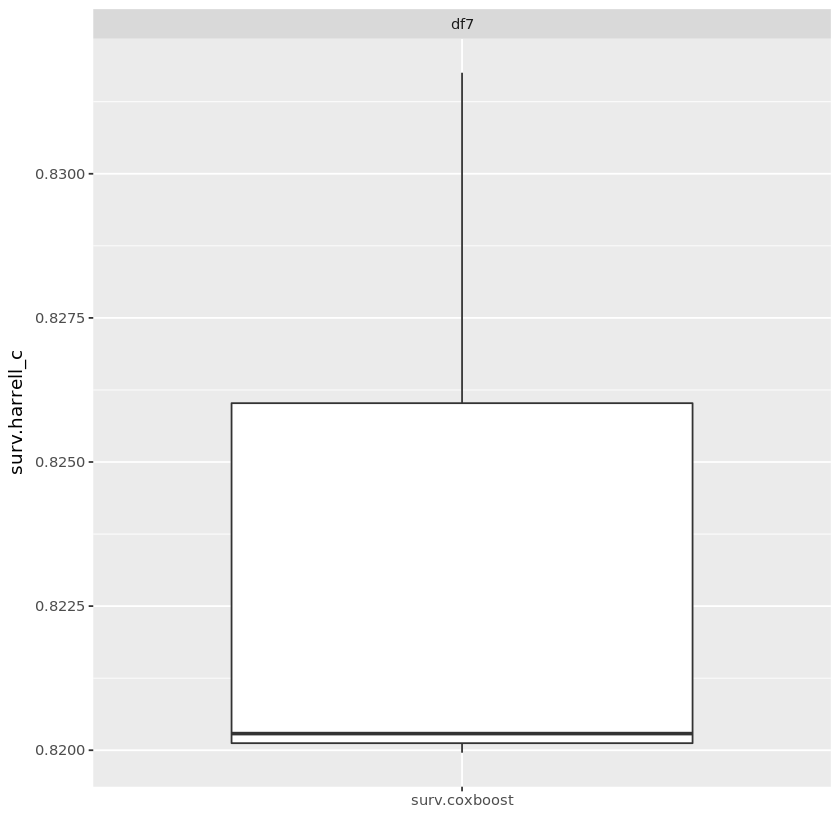

In [49]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [50]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 250),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 10)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_oh_d7, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [03:34:45.617] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df7' (iter 2/3) 
INFO  [03:34:45.650] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [03:34:45.654] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:34:45.680] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [03:34:45.690] [mlr3]  Applying learner 'surv.coxboost' on task 'df7' (iter 2/2) 
INFO  [03:34:54.886] [mlr3]  Applying learner 'surv.coxboost' on task 'df7' (iter 1/2) 
INFO  [03:35:03.619] [mlr3]  Finished benchmark 
INFO  [03:35:03.677] [bbotk] Result of batch 1: 
INFO  [03:35:03.679] [bbotk]  stepno  penalty stepsize.factor surv.harrell_c 
INFO  [03:35:03.679] [bbotk]     139 233.3333             8.9      0.8015354 
INFO  [03:35:03.679] [bbotk]                                 uhash 
INFO  [03:35:03.679] [bbotk]  ac6cfb58-e3f7-4ed2-ad21-6ab2c5adb104 
INFO  [03:35:03.681] [bbotk] Evaluating 1 configuration(s) 
INFO  [03:35:03.706

In [51]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.8127

surv.harrell_c 
     0.8127001

In [52]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 94

[[1]]$penalty
[1] 500

[[1]]$stepsize.factor
[1] 3.4

Step_3_4: Autoplot the pre and after tuning boxplots

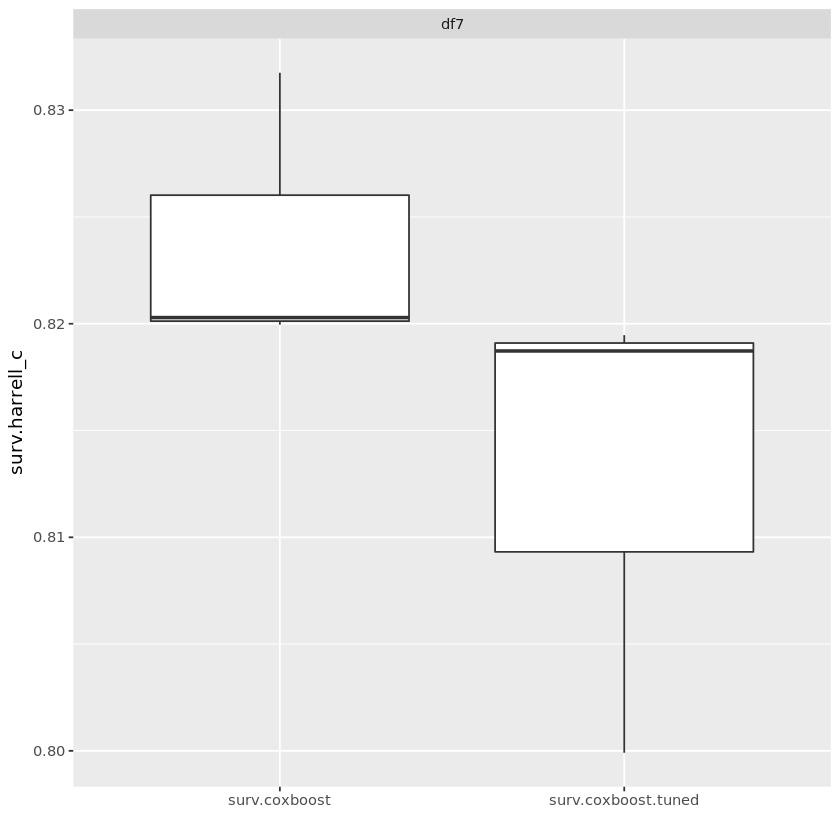

In [53]:
# autoplot the two boxplots
autoplot(c(cb_bmr, cb_bmr_2))